In [1]:
import os
from datetime import datetime, timezone
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR, SVR
from source.DataFrameSelector import DataFrameSelector

DATA_PATH = os.path.join("..", "data")

def load_csv(filename, path=DATA_PATH):
    return pd.read_csv(os.path.join(path, filename))

def mean_absolute_percentage_error(actual, forecast):
    return np.mean(np.abs(np.divide(np.subtract(actual, forecast), actual))) * 100

In [2]:
def to_utc_datetime(df, column="time"):
    df[column] = df.apply(lambda row: datetime.strptime(row[column], "%Y-%m-%d %H:%M:%S%z").astimezone(timezone.utc), axis=1)
    return df

def get_price():
    e_data = load_csv("energy_dataset.csv")
    return e_data[["time", "price", "price day ahead"]].rename(columns={"price day ahead": "TSO_price_forecast"})
    
def add_price_x_hours_before(df, hours):
    return df.join(df["price"].shift(periods=hours), lsuffix="", rsuffix="_%dh_before" % hours).dropna()

def add_weather_data(df):
    w_data = load_csv("weather_features.csv").drop(columns=["weather_id", "weather_icon", "temp_min", "temp_max"])
    w_data = w_data.join(other=df.set_index("time"), on="time").drop_duplicates(subset=["time", "city_name"])
    return w_data.reset_index(drop=True)

data = to_utc_datetime(add_weather_data(get_price()))

In [51]:
data.info()
#data["tmp"] = data[["time", "city_name"]].duplicated(keep=False)
#foo = data.loc[data["tmp"] == True]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175320 entries, 0 to 175319
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   time                 175320 non-null  datetime64[ns, UTC]
 1   city_name            175320 non-null  object             
 2   temp                 175320 non-null  float64            
 3   pressure             175320 non-null  int64              
 4   humidity             175320 non-null  int64              
 5   wind_speed           175320 non-null  int64              
 6   wind_deg             175320 non-null  int64              
 7   rain_1h              175320 non-null  float64            
 8   rain_3h              175320 non-null  float64            
 9   snow_3h              175320 non-null  float64            
 10  clouds_all           175320 non-null  int64              
 11  weather_main         175320 non-null  object             
 12  we

In [82]:
def foobar(weather):
    switch = {"clear": "",
              "clouds" : "",
              "rain" : "rain",
              "mist" : "fog",
              "fog" : "fog",
              "drizzle" : "rain",
              "thunderstorm" : "rain",
              "haze" : "dust",
              "dust" : "dust",
              "snow" : "",
              "smoke" : "",
              "squall" : "",
              }
    return switch[weather]

data["weather"] = data["weather_main"].apply(lambda weather: foobar(weather))
#data["weather_main"].value_counts()
#corr = data.corr()
#corr["price"].sort_values(ascending=False)

In [43]:
def import_data():
    e_data = load_csv("energy_dataset.csv")
    w_data = load_csv("weather_features.csv")
    # weather_id ist abgeleitet von clouds_all
    # weather_id ist die numerische klassifikation von weather_description
    # weather_main ist eine ungenaue darstellung von weather_description
    # weather_icon ist ?
    # in den meisten fällen ist temp = temp_min = temp_max
    w_data = w_data.drop(columns=["weather_id", "weather_icon", "temp_min", "temp_max"])
    return w_data.join(other=e_data[["time", "price"]].set_index("time"), on="time")

data = import_data()
data.head()
data["time"] = data.apply(lambda row: datetime.strptime(row["time"], "%Y-%m-%d %H:%M:%S%z").astimezone(timezone.utc), axis=1)

In [3]:
def calendar_week_max(year):
    # https://docs.python.org/3/library/datetime.html
    # see datetime.isocalendar() on why we take 28 instead of 31
    return datetime(year, 12, 28).isocalendar()[1]

def encode_cyclic(value, max_value):
    # min_value must be 0
    sin_coord = np.sin(2*np.pi*value/max_value)
    cos_coord = np.cos(2*np.pi*value/max_value)
    return sin_coord, cos_coord

def encode_date(utc_date: datetime):
    encoded_cw = encode_cyclic(utc_date.isocalendar()[1], calendar_week_max(utc_date.year))
    hours_in_week = (utc_date.isocalendar()[2] - 1) * 24 + utc_date.hour
    encoded_hour = encode_cyclic(hours_in_week, 7*24)
    return utc_date.isocalendar()[0], encoded_cw[0], encoded_cw[1], encoded_hour[0], encoded_hour[1] 


data["iso_year"], data["sin_kw"], data["cos_kw"], data["sin_h"], data["cos_h"] = zip(*data.apply(lambda row: encode_date(row["time"]), axis=1))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=["price"]), data["price"], test_size=0.2, random_state=42)

In [4]:
label = "price"
X_train = X_test = y_train = y_test = None
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["city_name"]):
    X_train = data.loc[train_index]
    y_train = X_train[label]
    X_train = X_train.drop(columns=[label])
    X_test = data.loc[test_index]
    y_test = X_test[label]
    X_test = X_test.drop(columns=[label])
    
X_test["city_name"].value_counts() / len(X_test)

Valencia      0.200006
 Barcelona    0.200006
Madrid        0.200006
Seville       0.200006
Bilbao        0.199977
Name: city_name, dtype: float64

In [30]:
cat_attribs = ["city_name"]
num_attribs = ["iso_year", "sin_kw", "cos_kw", "sin_h", "cos_h", 
               'temp', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 
               'rain_1h', 'rain_3h', 'snow_3h'
               ]
poly_attribs = ['temp', 'pressure', 'humidity', 'wind_speed', 'wind_deg']
degree = 2

num_pipeline = Pipeline([
    ("selector", DataFrameSelector(num_attribs)),
    #("std_scaler", StandardScaler())
])
cat_pipeline = Pipeline([
    ("selector", DataFrameSelector(cat_attribs)),
    ("cat_encoder", OneHotEncoder(sparse=False, handle_unknown="ignore"))
])
poly_pipeline = Pipeline([
    ("selector", DataFrameSelector(poly_attribs)),
    ("poly_features", PolynomialFeatures(degree=degree)),
    ("std_scaler", StandardScaler())
])
pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    #("poly_pipeline", poly_pipeline),
    ("cat_pipeline", cat_pipeline)
])
pipeline.fit(X_train)
X_prepared = pipeline.transform(X_train)

In [10]:
# X_train.iloc[0]
# X_prepared[0]

In [31]:
def foo(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))
    rmse_test = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
    return rmse_train, rmse_test

lin_reg = RandomForestRegressor()
print(foo(lin_reg, X_prepared, y_train, pipeline.transform(X_test), y_test))

# OneHotEncoded city_names: (0.6662357416737943, 1.757120495632516)
# city_names removed:       (0.6504949222158335, 1.692469767005644)

(0.6670890066864742, 1.7608051089398462)


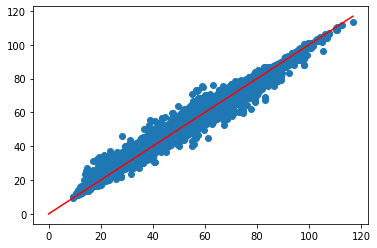

In [7]:
plt.scatter(y_test, lin_reg.predict(pipeline.transform(X_test)))
plt.plot([0, max(y_test)], [0, max(y_test)], color="red")
plt.show()

In [32]:
mean_absolute_percentage_error(y_test, lin_reg.predict(pipeline.transform(X_test)))
# mean_absolute_percentage_error(y_test, X_test["TSO_price_forecast"])

2.0788077622967474

In [13]:
tmp = X_test.copy(deep=True)
tmp["y"] = y_test
tmp["y_p"] = lin_reg.predict(pipeline.transform(X_test))
tmp = tmp.reset_index(drop=True)

In [9]:
X_embedded = TSNE(n_components=2).fit_transform(pipeline.transform(tmp))

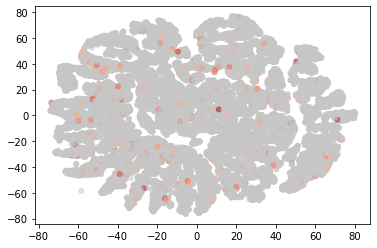

In [41]:
#X_embedded[0]
#c=[row["y"] - row["y_p"] for row in tmp]
colormap = cm.get_cmap("Reds", 100)
colormap = colormap(np.linspace(0, 1, 100))
colormap[:25, :] = np.array([200/256, 200/256, 200/256, 1])
colormap = colors.ListedColormap(colormap)
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=tmp["abs_d"], 
            norm=colors.Normalize().autoscale(tmp["abs_d"]), s=25, alpha=0.5,
            cmap=colormap)
plt.show()

In [20]:
tmp["d"] = tmp["y"] - tmp["y_p"]
tmp["abs_d"] = np.abs(tmp["d"])
tmp.info()
#tmp.apply(lambda row: row["y"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   time                 35064 non-null  datetime64[ns, UTC]
 1   city_name            35064 non-null  object             
 2   temp                 35064 non-null  float64            
 3   pressure             35064 non-null  int64              
 4   humidity             35064 non-null  int64              
 5   wind_speed           35064 non-null  int64              
 6   wind_deg             35064 non-null  int64              
 7   rain_1h              35064 non-null  float64            
 8   rain_3h              35064 non-null  float64            
 9   snow_3h              35064 non-null  float64            
 10  clouds_all           35064 non-null  int64              
 11  weather_main         35064 non-null  object             
 12  weather_descriptio

In [24]:
# bar = tmp.corr()
# bar["d"].sort_values(ascending=True)
tmp.groupby(["city_name"]).mean()

,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,TSO_price_forecast,iso_year,sin_kw,cos_kw,sin_h,cos_h,y,y_p,d,abs_d
city_name,,,,,,,,,,,,,,,,,,,
Barcelona,289.828051,1102.128191,73.960074,2.814773,189.305861,0.125809,0.000282,0.000000,22.510195,49.931330,2016.500071,0.005965,-0.001476,-0.019253,0.011816,57.780455,57.797579,-0.017124,1.031070
Bilbao,286.429402,1017.478608,78.798488,1.958928,159.751141,0.117399,0.000866,0.013134,43.175841,49.908935,2016.490302,0.004736,-0.004203,-0.004275,-0.004450,57.701055,57.691313,0.009742,1.125180
Madrid,288.304264,1011.628832,59.047483,2.420362,173.313133,0.043590,0.000140,0.000000,20.592471,50.050781,2016.488379,-0.020156,0.000637,-0.014359,-0.013387,58.140933,58.119670,0.021262,0.987799
Seville,293.131526,1018.477827,63.948524,2.433908,150.152859,0.040468,0.000149,0.000000,14.178953,49.699853,2016.477684,0.001401,-0.007331,0.003272,-0.006106,57.742578,57.759643,-0.017065,1.213363
Valencia,290.751818,1016.061742,65.419792,2.710823,160.403251,0.037680,0.000227,0.000014,21.298018,49.826308,2016.528875,-0.009245,0.008598,0.016729,-0.004098,57.988345,57.967289,0.021055,0.990571
